# Pyro Examples

In [1]:
import pandas as pd
import numpy as np
from orbit.lgt import LGT
from orbit.utils.plot import plot_predicted_data
from orbit.utils.plot import plot_predicted_components

In [2]:
pd.set_option('display.float_format', lambda x: '%.5f' % x)

## Data

In [3]:
DATA_FILE = "./data/iclaims_example.csv"

In [4]:
raw_df = pd.read_csv(DATA_FILE, parse_dates=['week'])

### Train / Test Split

In [5]:
df=raw_df.copy()
test_size=52
train_df=df[:-test_size]
test_df=df[-test_size:]

In [6]:
train_df.head(5)

,week,claims,trend.unemploy,trend.filling,trend.job
0,2010-01-03,651215,1.18397,0.72014,1.11967
1,2010-01-10,825891,1.18397,0.81490,1.17860
2,2010-01-17,659173,1.20338,0.73909,1.11967
3,2010-01-24,507651,1.16456,0.81490,1.10788
4,2010-01-31,538617,1.08693,0.77699,1.07253


## MAP Fit and Predict

In [7]:
lgt_map=LGT(
    response_col="claims",
    date_col="week",
    seasonality=52,
    seed=8888,
    inference_engine='pyro',
    sample_method='map',
    predict_method='map',
    auto_scale=False,
    is_multiplicative=True,
    verbose=True,
)

In [8]:
%%time
lgt_map.fit(df=train_df)

step    0 loss = 579.04
step  100 loss = -559.27
step  200 loss = -580.03
step  300 loss = -579.99
step  400 loss = -580.12
step  500 loss = -580.32
CPU times: user 59.8 s, sys: 941 ms, total: 1min
Wall time: 1min 2s


In [9]:
predicted_df = lgt_map.predict(df=test_df)

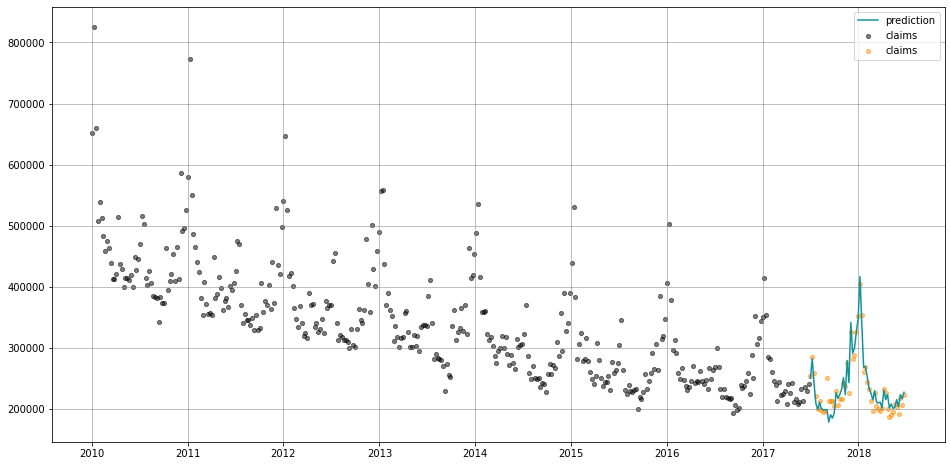

In [10]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=lgt_map.date_col, actual_col=lgt_map.response_col, pred_col='prediction', 
                    test_actual_df=test_df)

## VI Fit and Predict

Pyro only support Variational Inference(SVI) for full sampling prediction.

In [11]:
lgt_vi = LGT(
    response_col='claims',
    date_col='week',
    seasonality=52,
    num_warmup=4000, 
    num_sample=500,
    seed=8888,
    inference_engine='pyro',
    sample_method='vi',
    predict_method='full',
    n_bootstrap_draws=500,
    verbose=True,
)

In [12]:
%%time
lgt_vi.fit(df=train_df)

INFO:root:Guessed max_plate_nesting = 2


step    0 loss = 658.91, scale = 0.1069
step  100 loss = -441.54, scale = 0.42099
step  200 loss = -446.4, scale = 0.35427
step  300 loss = -447.08, scale = 0.33903
step  400 loss = -447.64, scale = 0.3564
step  500 loss = -446.48, scale = 0.33751
CPU times: user 9min 29s, sys: 17.9 s, total: 9min 46s
Wall time: 1min 34s


In [13]:
predicted_df = lgt_vi.predict(df=test_df)

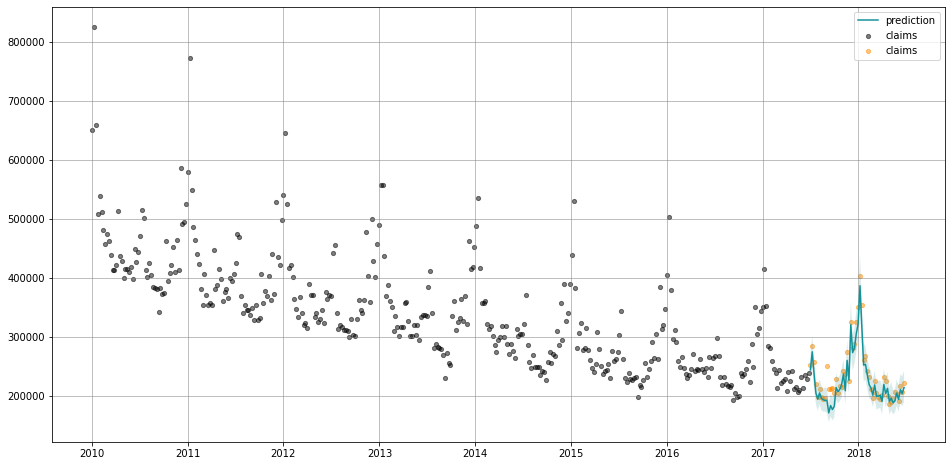

In [14]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=lgt_vi.date_col, actual_col=lgt_vi.response_col, pred_col=50, 
                    pred_quantiles_col=[5,95], test_actual_df=test_df)

## Fit with Regressors [with MAP]

**NOTE** the regression model with `vi` is currently unstable.

In [17]:
lgt_reg_map=LGT(
    response_col='claims',
    regressor_col=['trend.unemploy', 'trend.filling'],
    regressor_sign=['=','='],
    date_col='week',
    seasonality=52,
    seed=8888,
    inference_engine='pyro',
    sample_method='map',
    predict_method='map',
    verbose=True,
)

In [18]:
%%time
lgt_reg_map.fit(df=train_df)

step    0 loss = 433.4
step  100 loss = -563.19
step  200 loss = -578.69
step  300 loss = -578.74
step  400 loss = -579.1
step  500 loss = -579.05
CPU times: user 4min 25s, sys: 2.34 s, total: 4min 27s
Wall time: 1min 7s


In [19]:
predicted_df = lgt_reg_map.predict(df=test_df)

In [20]:
predicted_df.head(5)

,week,prediction
0,2017-07-02,245275.22621
1,2017-07-09,274963.15970
2,2017-07-16,234858.79503
3,2017-07-23,201966.05305
4,2017-07-30,194578.55070


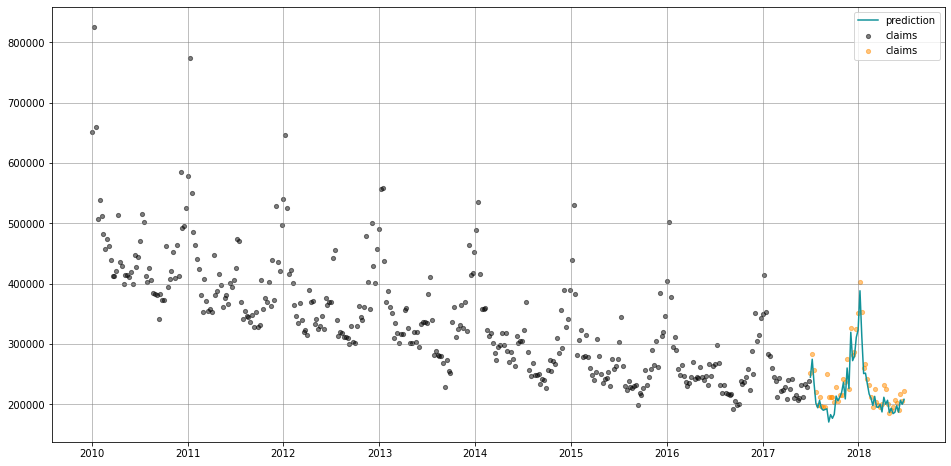

In [21]:
plot_predicted_data(training_actual_df=train_df, predicted_df=predicted_df, 
                    date_col=lgt_reg_map.date_col, actual_col=lgt_reg_map.response_col, pred_col='prediction', 
                    test_actual_df=test_df)

In [22]:
predicted_df = lgt_reg_map.predict(df=df, decompose=True)
predicted_df.head(5)

,week,prediction,trend,seasonality,regression
0,2010-01-03,651215.00000,489824.20262,1.36116,0.97673
1,2010-01-10,808071.65185,477495.30599,1.71032,0.98947
2,2010-01-17,646290.14044,477214.34336,1.38134,0.98042
3,2010-01-24,505644.28499,476893.26685,1.07271,0.98842
4,2010-01-31,521199.65242,475447.12080,1.11959,0.97914


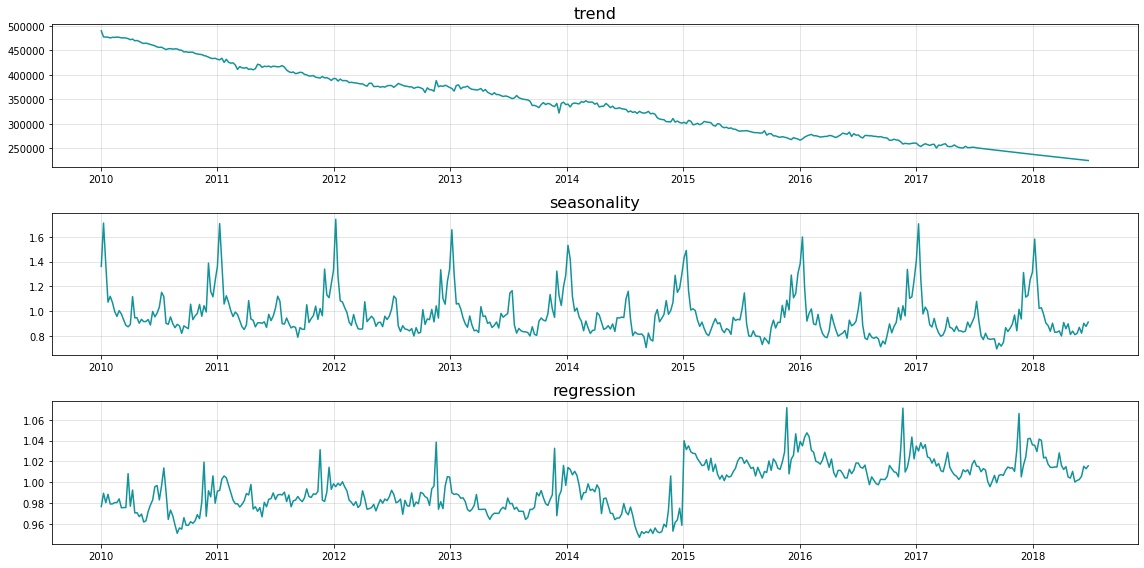

In [23]:
plot_predicted_components(predicted_df=predicted_df, date_col='week')